### Capstone 2

[Dataset](https://www.phoenixopendata.com/dataset/crime-data) downloaded on 9/25/2019 from the City of Phoenix Open Data Portal.  Includes crime data from 2015 to the present.

#### General Structure
1. Analysis that highlights your experimental hypothesis.
    - I have identified that motor vehicle thefts take place most frequently in xxx zip codes at xxx times of the day
1. A rollout plan showing how you would implement and rollout the experiment
    - I propose to increase the police presence in the above zip codes by 10% during the periods of the day when vehicle thefts are most likely to take place
1. An evaluation plan showing what constitutes success in this experiment
    - identify the incremental police force cost associated with each stolen vehicle
    - compare vehicle theft volumes after implementing the experiement with theft volumes before the experiment
    - if the decrease in theft volumes is statistically significant so as to justify the extra police force, then this experiment would be proved successful.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
%matplotlib inline 
plt.style.use('bmh')
# pd.options.display.max_rows = 999
pd.options.display.float_format = '{:.0f}'.format

In [3]:
# read in csv files
df = pd.read_csv('crime-data_crime-data_crimestat.csv', low_memory=False)

In [4]:
# convert column labels to lower case and remove spaces from column names
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [5]:
df.head()

,inc_number,occurred_on,occurred_to,ucr_crime_category,100_block_addr,zip,premise_type
0,201500002101405,11/01/2015 00:00,11/01/2015 05:00,MOTOR VEHICLE THEFT,102XX W MEDLOCK AVE,85307,SINGLE FAMILY HOUSE
1,201500002102668,11/01/2015 00:00,11/01/2015 11:50,MOTOR VEHICLE THEFT,69XX W WOOD ST,85043,SINGLE FAMILY HOUSE
2,201600000052855,11/01/2015 00:00,01/09/2016 00:00,MOTOR VEHICLE THEFT,N 43RD AVE & W CACTUS RD,85029,SINGLE FAMILY HOUSE
3,201500002168686,11/01/2015 00:00,11/11/2015 09:30,LARCENY-THEFT,14XX E HIGHLAND AVE,85014,PARKING LOT
4,201700001722914,11/01/2015 00:00,NaN,LARCENY-THEFT,279XX N 23RD LN,85085,SINGLE FAMILY HOUSE


In [6]:
df.dtypes

inc_number             object
occurred_on            object
occurred_to            object
ucr_crime_category     object
100_block_addr         object
zip                   float64
premise_type           object
dtype: object

In [7]:
# change date and time columns to datetime format
df.occurred_on = pd.to_datetime(df.occurred_on)
df.occurred_to = pd.to_datetime(df.occurred_to)

In [8]:
# add datetime features
df['occ_on_month'] = df['occurred_on'].dt.month
df['occ_on_year'] = df['occurred_on'].dt.year

In [9]:
# how large is the dataset
df.shape

(253000, 9)

### Explore Data

In [10]:
# how many different types of crime are there?
df.ucr_crime_category.value_counts()

LARCENY-THEFT                            128579
BURGLARY                                  40684
MOTOR VEHICLE THEFT                       26801
DRUG OFFENSE                              21111
AGGRAVATED ASSAULT                        19280
ROBBERY                                   10744
RAPE                                       3722
ARSON                                      1568
MURDER AND NON-NEGLIGENT MANSLAUGHTER       511
Name: ucr_crime_category, dtype: int64

In [11]:
# create column for hour of day
df['occ_on_hr'] = df.occurred_on.dt.hour

In [12]:
# this doesn't work
# df.groupby(df.ucr_crime_category)['occurred_on'].dt.hour.mean()

pd.options.display.float_format = '{:.2f}'.format
df.groupby(df.ucr_crime_category)['occ_on_hr'].mean()

ucr_crime_category
AGGRAVATED ASSAULT                      12.95
ARSON                                   10.55
BURGLARY                                11.44
DRUG OFFENSE                            12.89
LARCENY-THEFT                           13.15
MOTOR VEHICLE THEFT                     13.06
MURDER AND NON-NEGLIGENT MANSLAUGHTER   11.75
RAPE                                    10.10
ROBBERY                                 12.90
Name: occ_on_hr, dtype: float64

In [13]:
# difference in time between when crime began and ended
# why are there so many negative numbers?

(df.occurred_on.dt.hour - df.occurred_to.dt.hour).value_counts().head()

0.00     68872
-1.00    17501
-2.00     7756
-3.00     5402
-4.00     4581
dtype: int64

In [14]:
# which street locations have the most crimes
df['100_block_addr'].value_counts().head()

18XX W BELL RD            1619
61XX N 35TH AVE           1333
57XX N 19TH AVE           1225
16XX W BETHANY HOME RD    1056
37XX E THOMAS RD          1044
Name: 100_block_addr, dtype: int64

In [15]:
# where do most crimes take place at?
df.premise_type.value_counts().head(10)

SINGLE FAMILY HOUSE                    44658
APARTMENT                              28929
STREET / ROADWAY / ALLEY / SIDEWALK    25542
PARKING LOT                            25361
RETAIL BUSINESS                        19515
VEHICLE                                13107
CONVENIENCE MARKET / STORE              9192
DEPARTMENT / DISCOUNT STORE             8872
DRIVEWAY                                8833
GROCERY / SUPER MARKET                  6917
Name: premise_type, dtype: int64

### Motor Vehicle Thefts

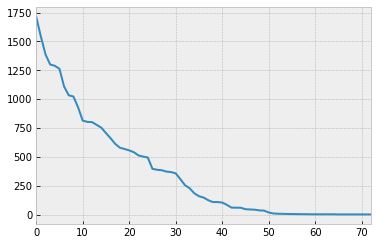

In [65]:
# zips with the most vehicle thefts
df.groupby(df.ucr_crime_category).get_group('MOTOR VEHICLE THEFT').loc[:,'zip'] \
    .value_counts().plot(use_index=False)

In [72]:
df.groupby(df.ucr_crime_category).get_group('MOTOR VEHICLE THEFT').loc[:,'zip'] \
    .value_counts().reset_index().head(10)

,index,zip
0,85009,1714
1,85041,1543
2,85033,1388
3,85043,1300
4,85035,1289
5,85008,1263
6,85017,1109
7,85015,1033
8,85051,1023
9,85040,930


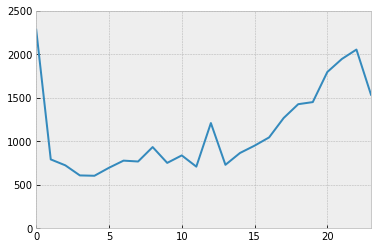

In [60]:
# what time of the day do most vehicle thefts take place at?
pd.options.display.float_format = '{:.0f}'.format
df.groupby(df.ucr_crime_category).get_group('MOTOR VEHICLE THEFT').loc[:,'occ_on_hr'] \
    .value_counts(sort=False).sort_index().plot(ylim=(0, 2500))

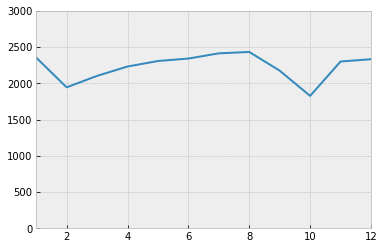

In [61]:
# how do vehicle thefts change during the year?
df.groupby(df.ucr_crime_category).get_group('MOTOR VEHICLE THEFT').loc[:,'occ_on_month'] \
    .value_counts().sort_index().plot(ylim=(0, 3000))